## Automated Surface Event Detection from Seismograms
Author: Akash Kharita
    
This notebook demonstrates how to use my machine learning model to detect surface events (snow avalanches/rockfalls/debris flows) through continuous seismograms from multiple station. We will take examples of verified events and see how my model/detector behaves around the event. 


Feel free to run this model on the starttimes and durations you would like!

## Importing dependencies


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import random
import pickle
from datetime import datetime
from glob import glob
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import h5py
import obspy
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from scipy import stats, signal
from tqdm import tqdm
from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms

# Add custom module path
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom utilities and models
import seis_feature
from utils import apply_cosine_taper, butterworth_filter, resample_array
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

# Download dataset from Zenodo
doi = '10.5281/zenodo.13334838'
from zenodo_get import zenodo_get
files = zenodo_get([doi])

# Import classification functions
from all_models_classification import (
    compute_window_probs, plot_single_model_probs, plot_all_model_probs
)




cuda


Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB

Checksum is correct. (7398572baf267d603e53e0203340cc8f)

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (cb4201470bac8fc1a7c19a20775ef95c)

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (5978efd4b65ea406248f2bbb5db66e2f)

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB

Checksum is correct. (491182443ae7eb720ba981e80f209323)

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_top_20_P_10_30_F_05_15_50.joblib   size: 

In [3]:
from all_models_classification import compute_window_probs
from all_models_classification import plot_all_model_probs
from all_models_classification import plot_single_model_probs

## Downloading the model and scaler parameters


Now we are downloading the trained model and scaler parameters files stored remotely on a Zenodo repository. 
We are downloading three trained random forest models and corresponding scaler parameter files. 

The nomenclature of the model is as follows - P_before_after_F_lowcut_highcut_new sampling rate
So for example if the file is named as P_10_30_F_1_15_50, that means that the model is trained on the waveforms that start 10s before the first arrival and 30 



Description
This dataset contains three trained  random forest models named as following - 

- P_10_100_F_05_15_50.joblib - This is a model trained on 110s long waveforms (origin time - 10, origin time +100) in case of earthquakes and explosions and (first arrival pick -10, first arrival pick + 100) in case of surface events, the waveforms are tapered using 10% cosine taper, bandpass filtered between 0.5-15 Hz using Butterworth four corner filter, normalized and resampled to 50 Hz. 
- P_50_100_F_05_15_50.joblib 
- P_10_30_F_05_15_50.joblib. 


And also the standard scaler parameters for each features that will be used to normalize them. 

## Loading the machine learning models

In [4]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cpu"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_deep_learning_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_1013049/2063820159.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_Sei

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

![Mount Rainier Stations](../Extras/Cover_Image.png)


![Mount Rainier Glaciers](../Extras/Mt_Rainier_Glaciers.png)

## First We will try our surface event detector to detect a snow avalanche that occurred on Carbon Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20011713 and we can also see a video of the event here - https://www.facebook.com/100003168843736/videos/2824127924369475/


- Event type: Snow Avalanche
- Start Date: 	2020-04-09 13:28:41
- End Date: 2020-04-09 13:29:54
- Location: Carbon Glacier


In [5]:
before = 100
start_time = obspy.UTCDateTime(2020, 4, 9, 13, 28, 41) - before
end_time = start_time + 300
        
stations_id = ['UW.STAR', 'UW.RCS', 'UW.RCM', 'CC.OBSR']
location = "*"

In [6]:
# Initialize client for accessing IRIS web services
client = Client("IRIS")

# Define parameters for signal processing
orig_sr = 100  # Original sampling rate in Hz
new_sr = 50    # New sampling rate in Hz
stride = 10 * orig_sr  # Stride value for processing windows (10 times original sampling rate)
lowpass = 1  # Lowpass filter cutoff frequency in Hz
highpass = 20  # Highpass filter cutoff frequency in Hz
window_length = 100  # Length of the window for processing in samples
channel_patterns = ["EH", "BH", "HH"]  # Channel patterns to filter

# Function to process and compute probabilities for seismic models
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    """
    This function computes the probabilities for a given model, station data, and time window.
    
    Args:
        model: The model used for classification (e.g., deep learning or machine learning).
        stations_id: List of station IDs for data collection.
        location: Location of the station (wildcard "*" to match all locations).
        start_time: Start time of the seismic event (obspy.UTCDateTime object).
        end_time: End time of the seismic event (obspy.UTCDateTime object).
        one_d: Boolean indicating whether the model is 1D or 2D.
        model_type: Type of the model, either 'dl' for deep learning or 'ml' for machine learning.
        filename: Name of the output file to save results.
    
    Returns:
        tuple: Processed probabilities and other output data.
    """
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )

# Compute probabilities for different deep learning models

# 1D model: QuakexNet
stn_probs_quakexnet_1d, _, big_station_ids = process_model(
    model_quakexnet_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: QuakexNet
stn_probs_quakexnet_2d, big_reshaped_data, _ = process_model(
    model_quakexnet_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 1D model: SeismicCNN
stn_probs_seismiccnn_1d, _, _ = process_model(
    model_seismiccnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)

# 2D model: SeismicCNN
stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)

# Machine Learning model probabilities
# The model parameter is irrelevant for ML models (use any model)
model = model_quakexnet_1d  # Example ML model

# 40 Hz frequency model (ML)
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)

# 110 Hz frequency model (ML)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)

# 150 Hz frequency model (ML)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCS. Skipping.


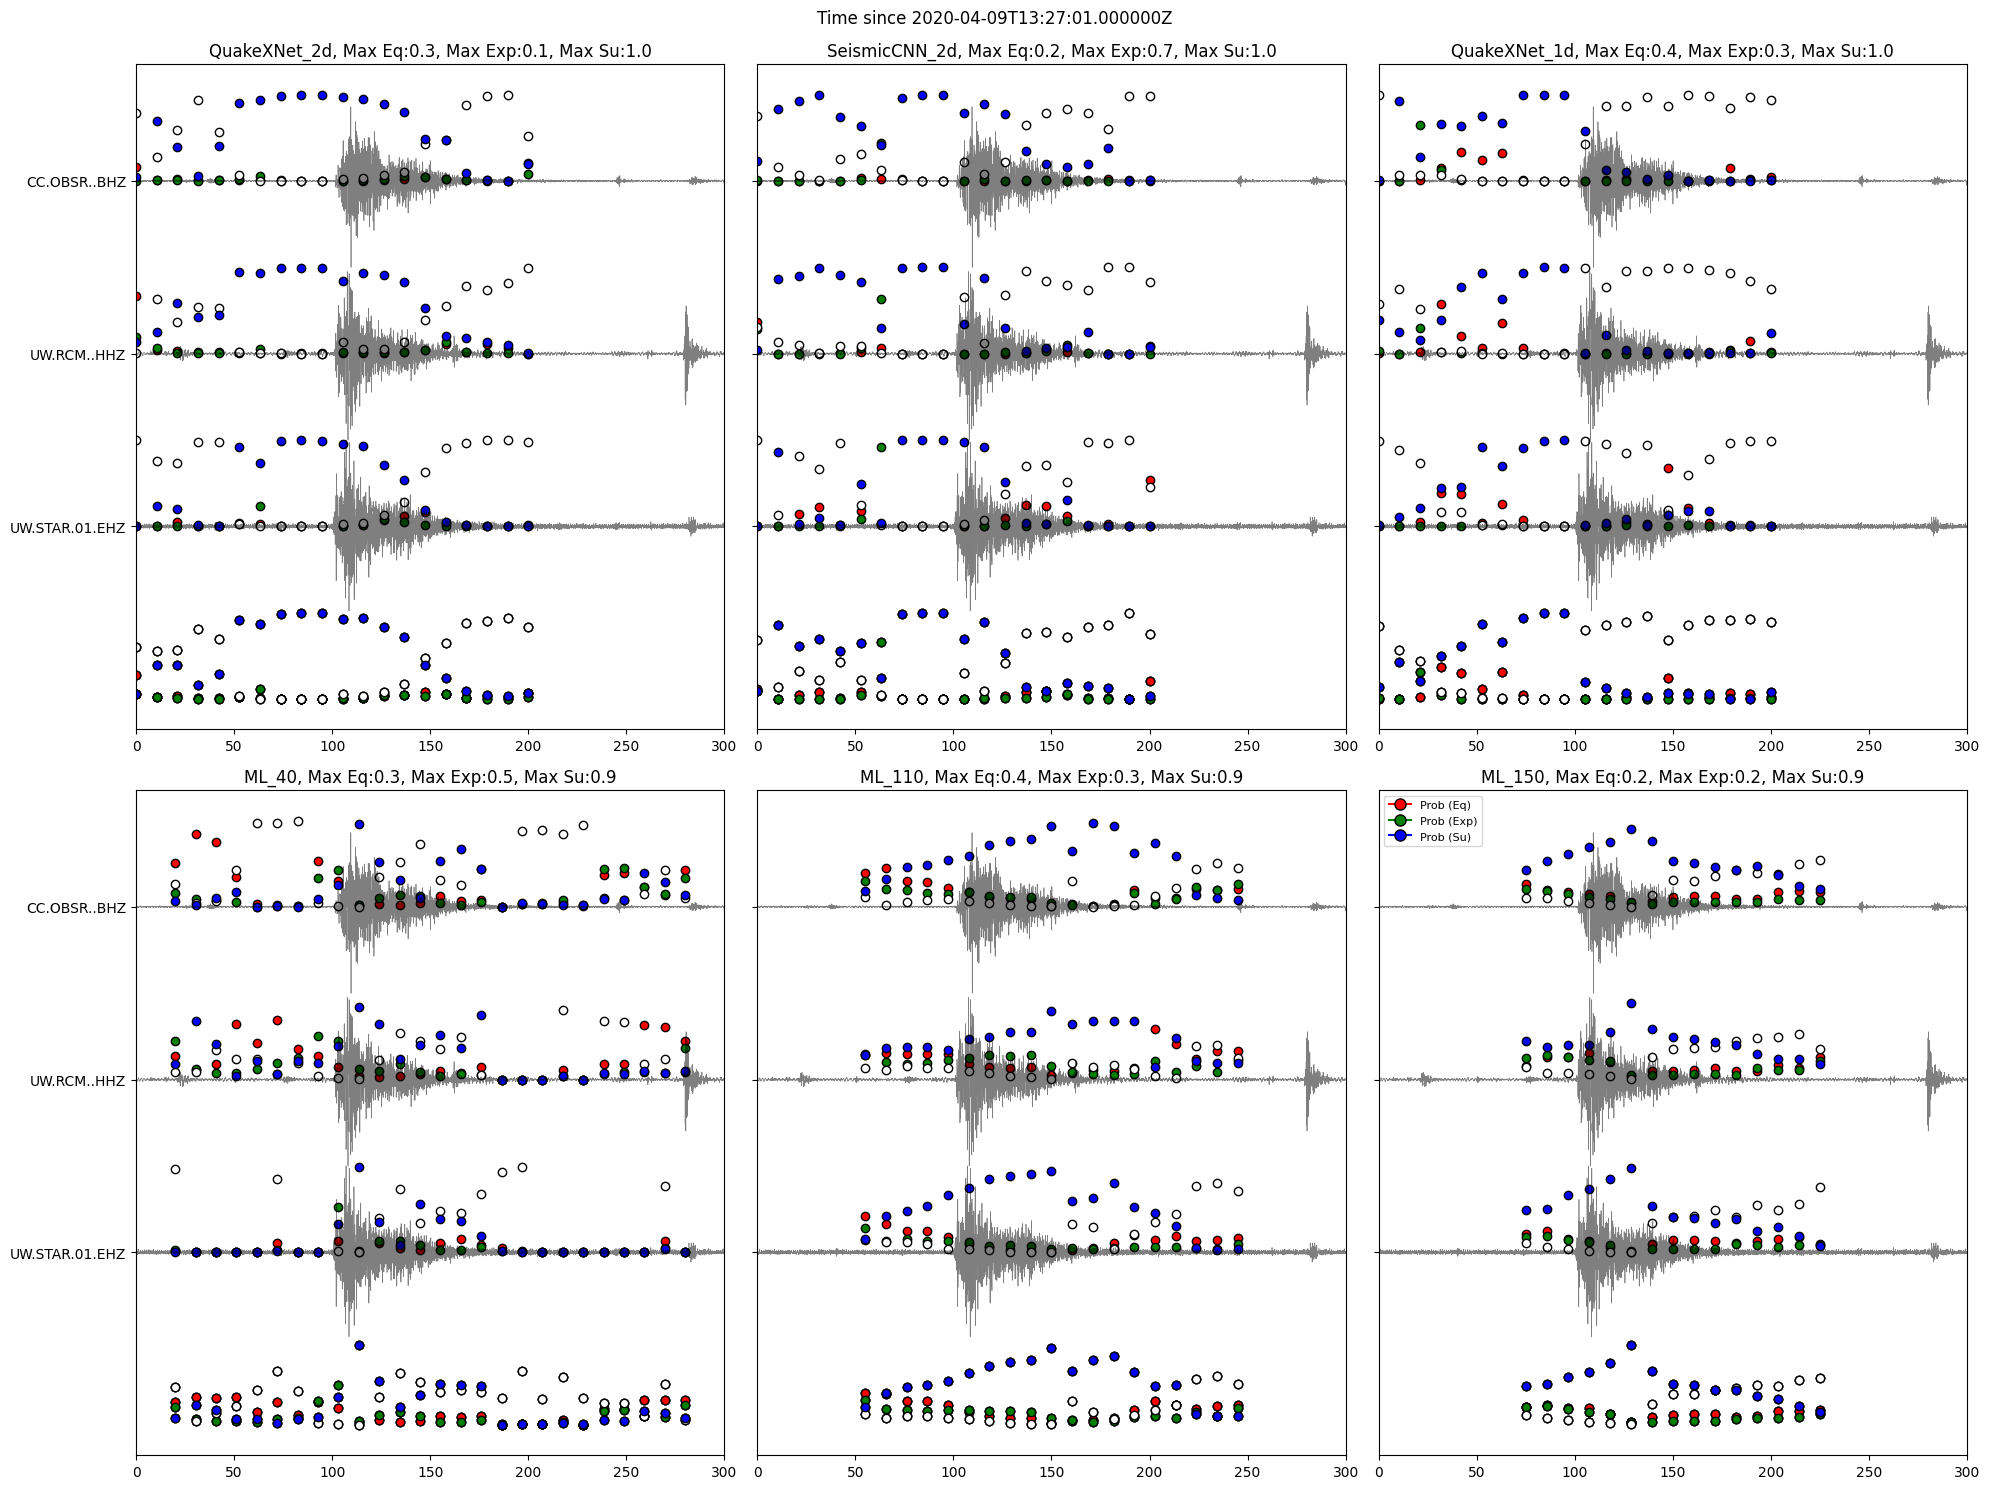

In [7]:
stn_probs_dl = [(stn_probs_quakexnet_2d, 'QuakeXNet_2d'), (stn_probs_seismiccnn_2d, 'SeismicCNN_2d'), (stn_probs_quakexnet_1d, 'QuakeXNet_1d')]
stn_probs_ml = [(stn_probs_ml_40, 'ML_40', 40), (stn_probs_ml_110, 'ML_110', 110), (stn_probs_ml_150, 'ML_150', 150)]
plot_all_model_probs(stn_probs_dl, stn_probs_ml, big_reshaped_data, orig_sr, start_time, end_time, big_station_ids)


## Second We will try our surface event detector to detect a Icefall and Ice Avalanche that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/14743775 and we can also see a video of the event here - https://www.youtube.com/watch?v=iDle-31t238


- Event type: Rockfall, Rock and Ice Avalanche
- Start Date: 	2011-06-25 23:04:05
- End Date: 2011-06-25 23:11:15
- Location: Nisqually Glacier


In [8]:
before = 100
start_time = obspy.UTCDateTime(2011, 6, 25, 23, 4, 5) - before
end_time = start_time + 300
        
stations_id = ['UW.RCS', 'UW.RCM', 'CC.PARA', 'CC.COPP', 'CC.PANH', 'CC.OBSR']
location = "*"

## We will also first modularize our code to avoid repetitive operations

In [9]:
def compute_model_preds(start_time, end_time, stations_id, location):

    client = Client("IRIS")

    # Define parameters
    orig_sr = 100  # original sampling rate
    new_sr = 50    # new sampling rate
    stride = 10 * orig_sr
    lowpass = 1
    highpass = 20
    window_length = 100
    channel_patterns = ["EH", "BH", "HH"]

    # Function to process and compute probabilities for seismic models
    def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
        """
        This function computes the probabilities for a given model, station data, and time window.

        Args:
            model: The model used for classification (e.g., deep learning or machine learning).
            stations_id: List of station IDs for data collection.
            location: Location of the station (wildcard "*" to match all locations).
            start_time: Start time of the seismic event (obspy.UTCDateTime object).
            end_time: End time of the seismic event (obspy.UTCDateTime object).
            one_d: Boolean indicating whether the model is 1D or 2D.
            model_type: Type of the model, either 'dl' for deep learning or 'ml' for machine learning.
            filename: Name of the output file to save results.

        Returns:
            tuple: Processed probabilities and other output data.
        """
        return compute_window_probs(
            stations_id=stations_id, location=location, start_time=start_time, 
            end_time=end_time, channel_patterns=channel_patterns, client=client, 
            stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
            lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
            model_type=model_type, filename=filename
        )

    # Compute probabilities for different deep learning models

    # 1D model: QuakexNet
    stn_probs_quakexnet_1d, _, big_station_ids = process_model(
        model_quakexnet_1d, stations_id, location, start_time, end_time, 
        one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
    )

    # 2D model: QuakexNet
    stn_probs_quakexnet_2d, big_reshaped_data, _ = process_model(
        model_quakexnet_2d, stations_id, location, start_time, end_time, 
        one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
    )

    # 1D model: SeismicCNN
    stn_probs_seismiccnn_1d, _, _ = process_model(
        model_seismiccnn_1d, stations_id, location, start_time, end_time, 
        one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
    )

    # 2D model: SeismicCNN
    stn_probs_seismiccnn_2d, _, _ = process_model(
        model_seismiccnn_2d, stations_id, location, start_time, end_time, 
        one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
    )

    # Machine Learning model probabilities
    # The model parameter is irrelevant for ML models (use any model)
    model = model_quakexnet_1d  # Example ML model

    # 40 Hz frequency model (ML)
    stn_probs_ml_40, _, _ = process_model(
        model, stations_id, location, start_time, end_time, 
        one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
    )

    # 110 Hz frequency model (ML)
    stn_probs_ml_110, _, _ = process_model(
        model, stations_id, location, start_time, end_time, 
        one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
    )

    # 150 Hz frequency model (ML)
    stn_probs_ml_150, _, _ = process_model(
        model, stations_id, location, start_time, end_time, 
        one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
    )


    
    stn_probs_dl = [(stn_probs_quakexnet_2d, 'QuakeXNet_2d'), (stn_probs_seismiccnn_2d, 'SeismicCNN_2d'), (stn_probs_quakexnet_1d, 'QuakeXNet_1d')]
    stn_probs_ml = [(stn_probs_ml_40, 'ML_40', 40), (stn_probs_ml_110, 'ML_110', 110), (stn_probs_ml_150, 'ML_150', 150)]
    plot_all_model_probs(stn_probs_dl, stn_probs_ml, big_reshaped_data, orig_sr, start_time, end_time, big_station_ids)

    

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station COPP. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station COPP. Skipping.
No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping

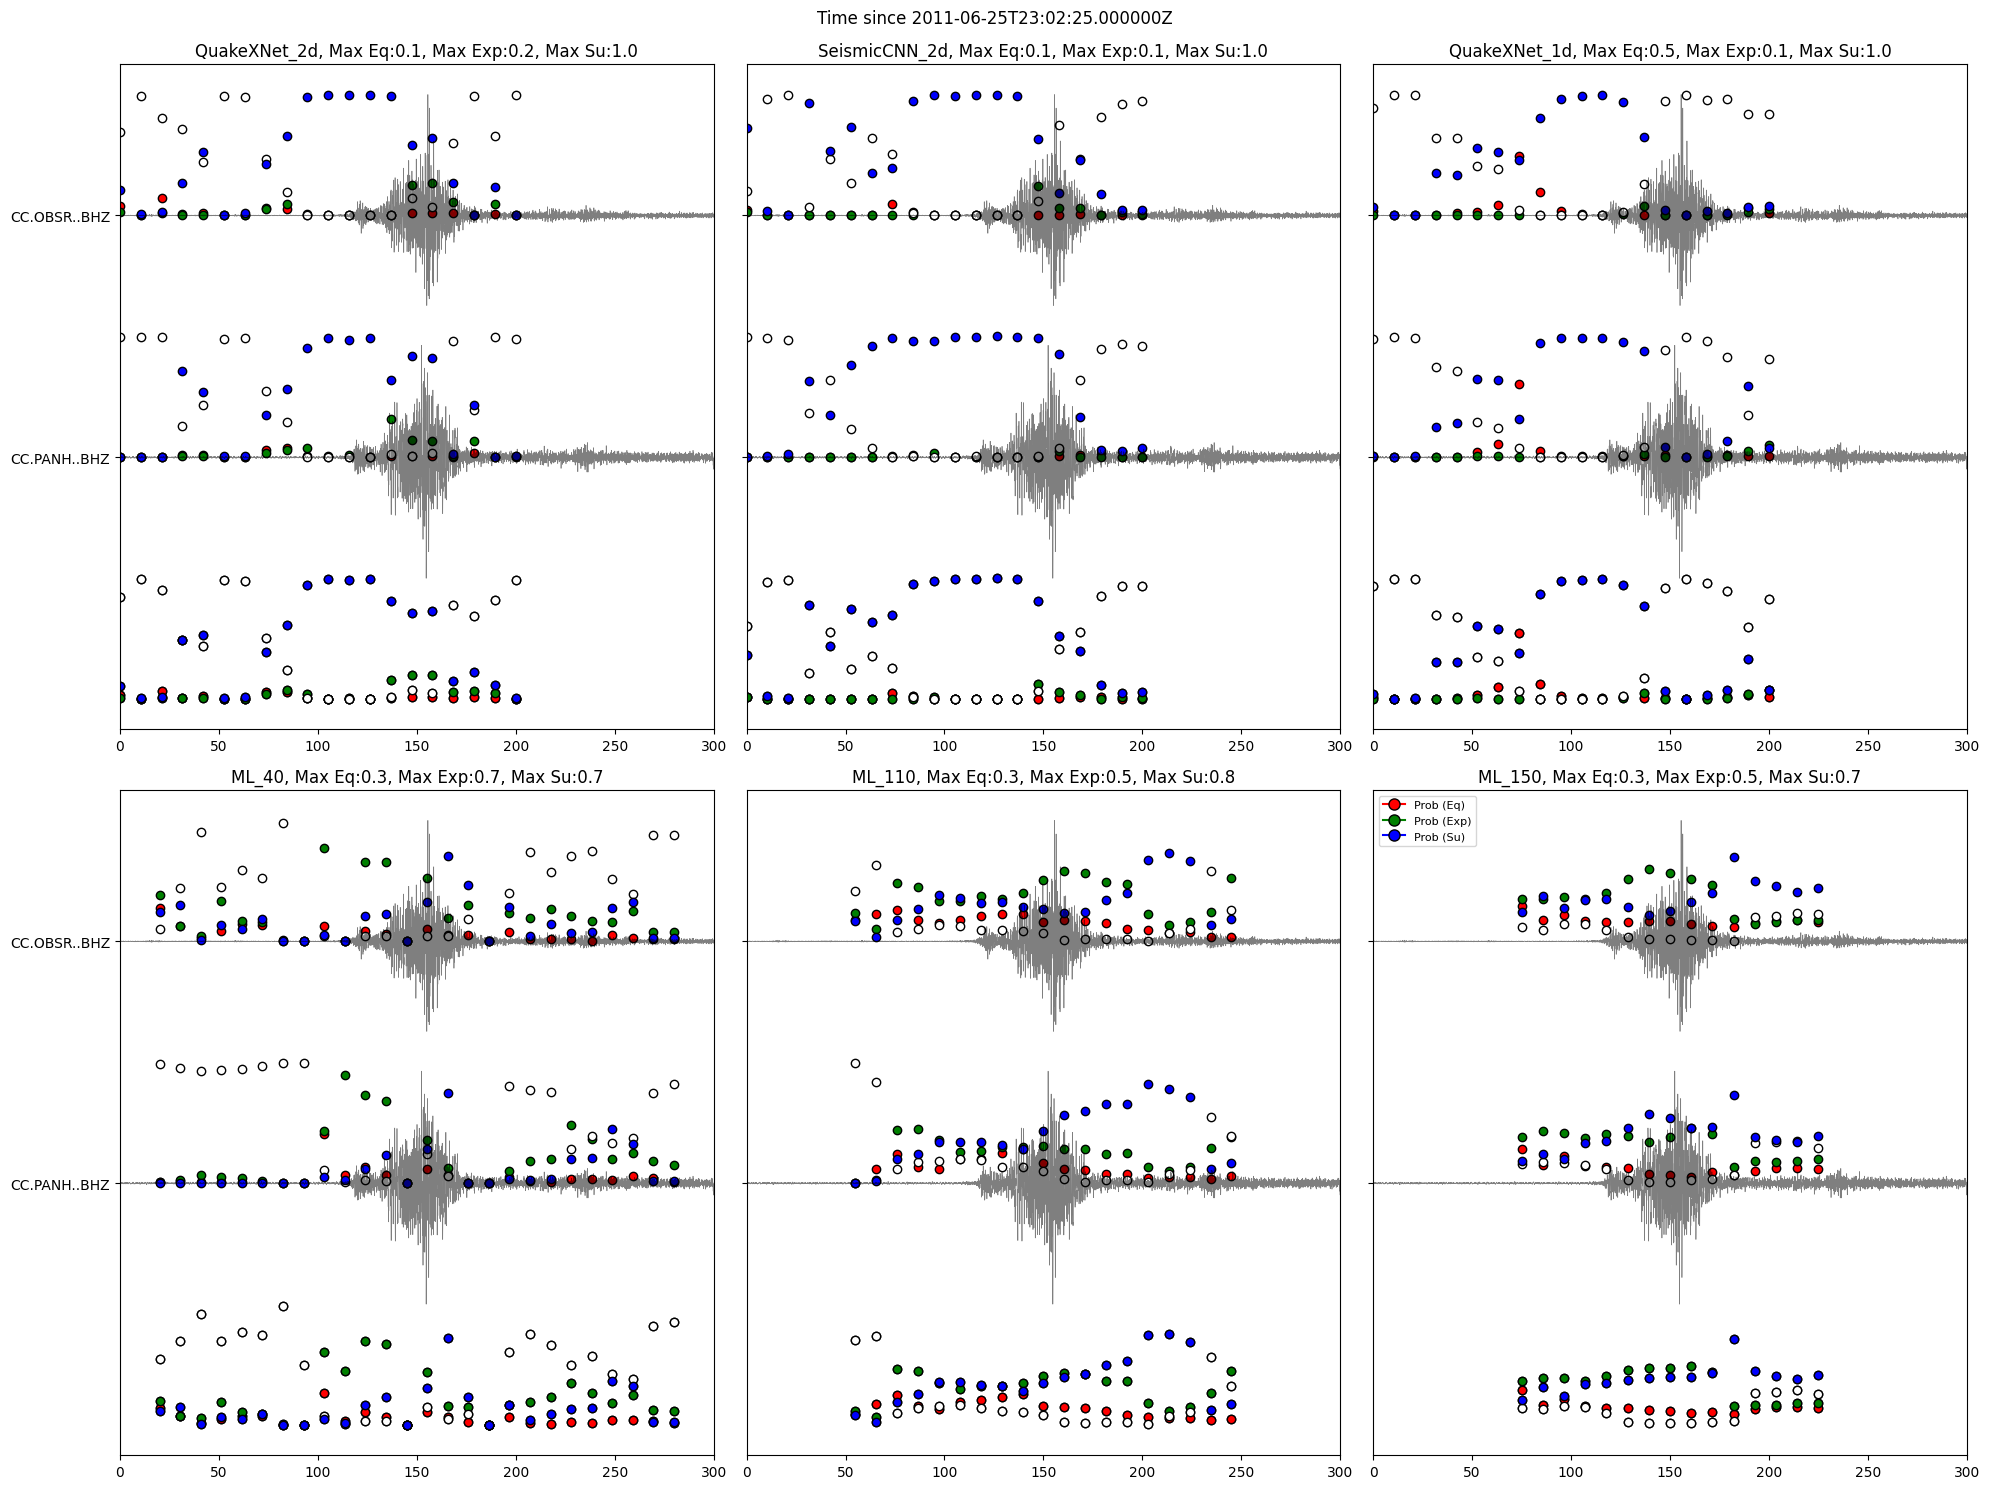

In [10]:
compute_model_preds(start_time, end_time, stations_id, location)

## Third We will try our surface event detector to detect a Debris Flow that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20008839 and we can also see more info of the event here - 


- Event type: Debris Flow
- Start Date: 	2019-09-27 00:43:20
- End Date: 	2019-09-27 01:29:22
- Location: Mount Rainier


In [11]:
before = 100
start_time = obspy.UTCDateTime(2019, 9, 27, 0, 43, 20) - before
end_time = start_time + 300
        
stations_id = [ 'UW.LON', 'UW.RER','UW.LO2', 'UW.RCS', 'UW.RCM', 'UW.STAR', 'CC.PARA', 'CC.MIRR', 'CC.TABR']
location = "*"

No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for PARA: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station MIRR. Skipping.
Error fetching station data for TABR: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station TABR. Skipping.
No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for PARA: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station PARA. Skipping

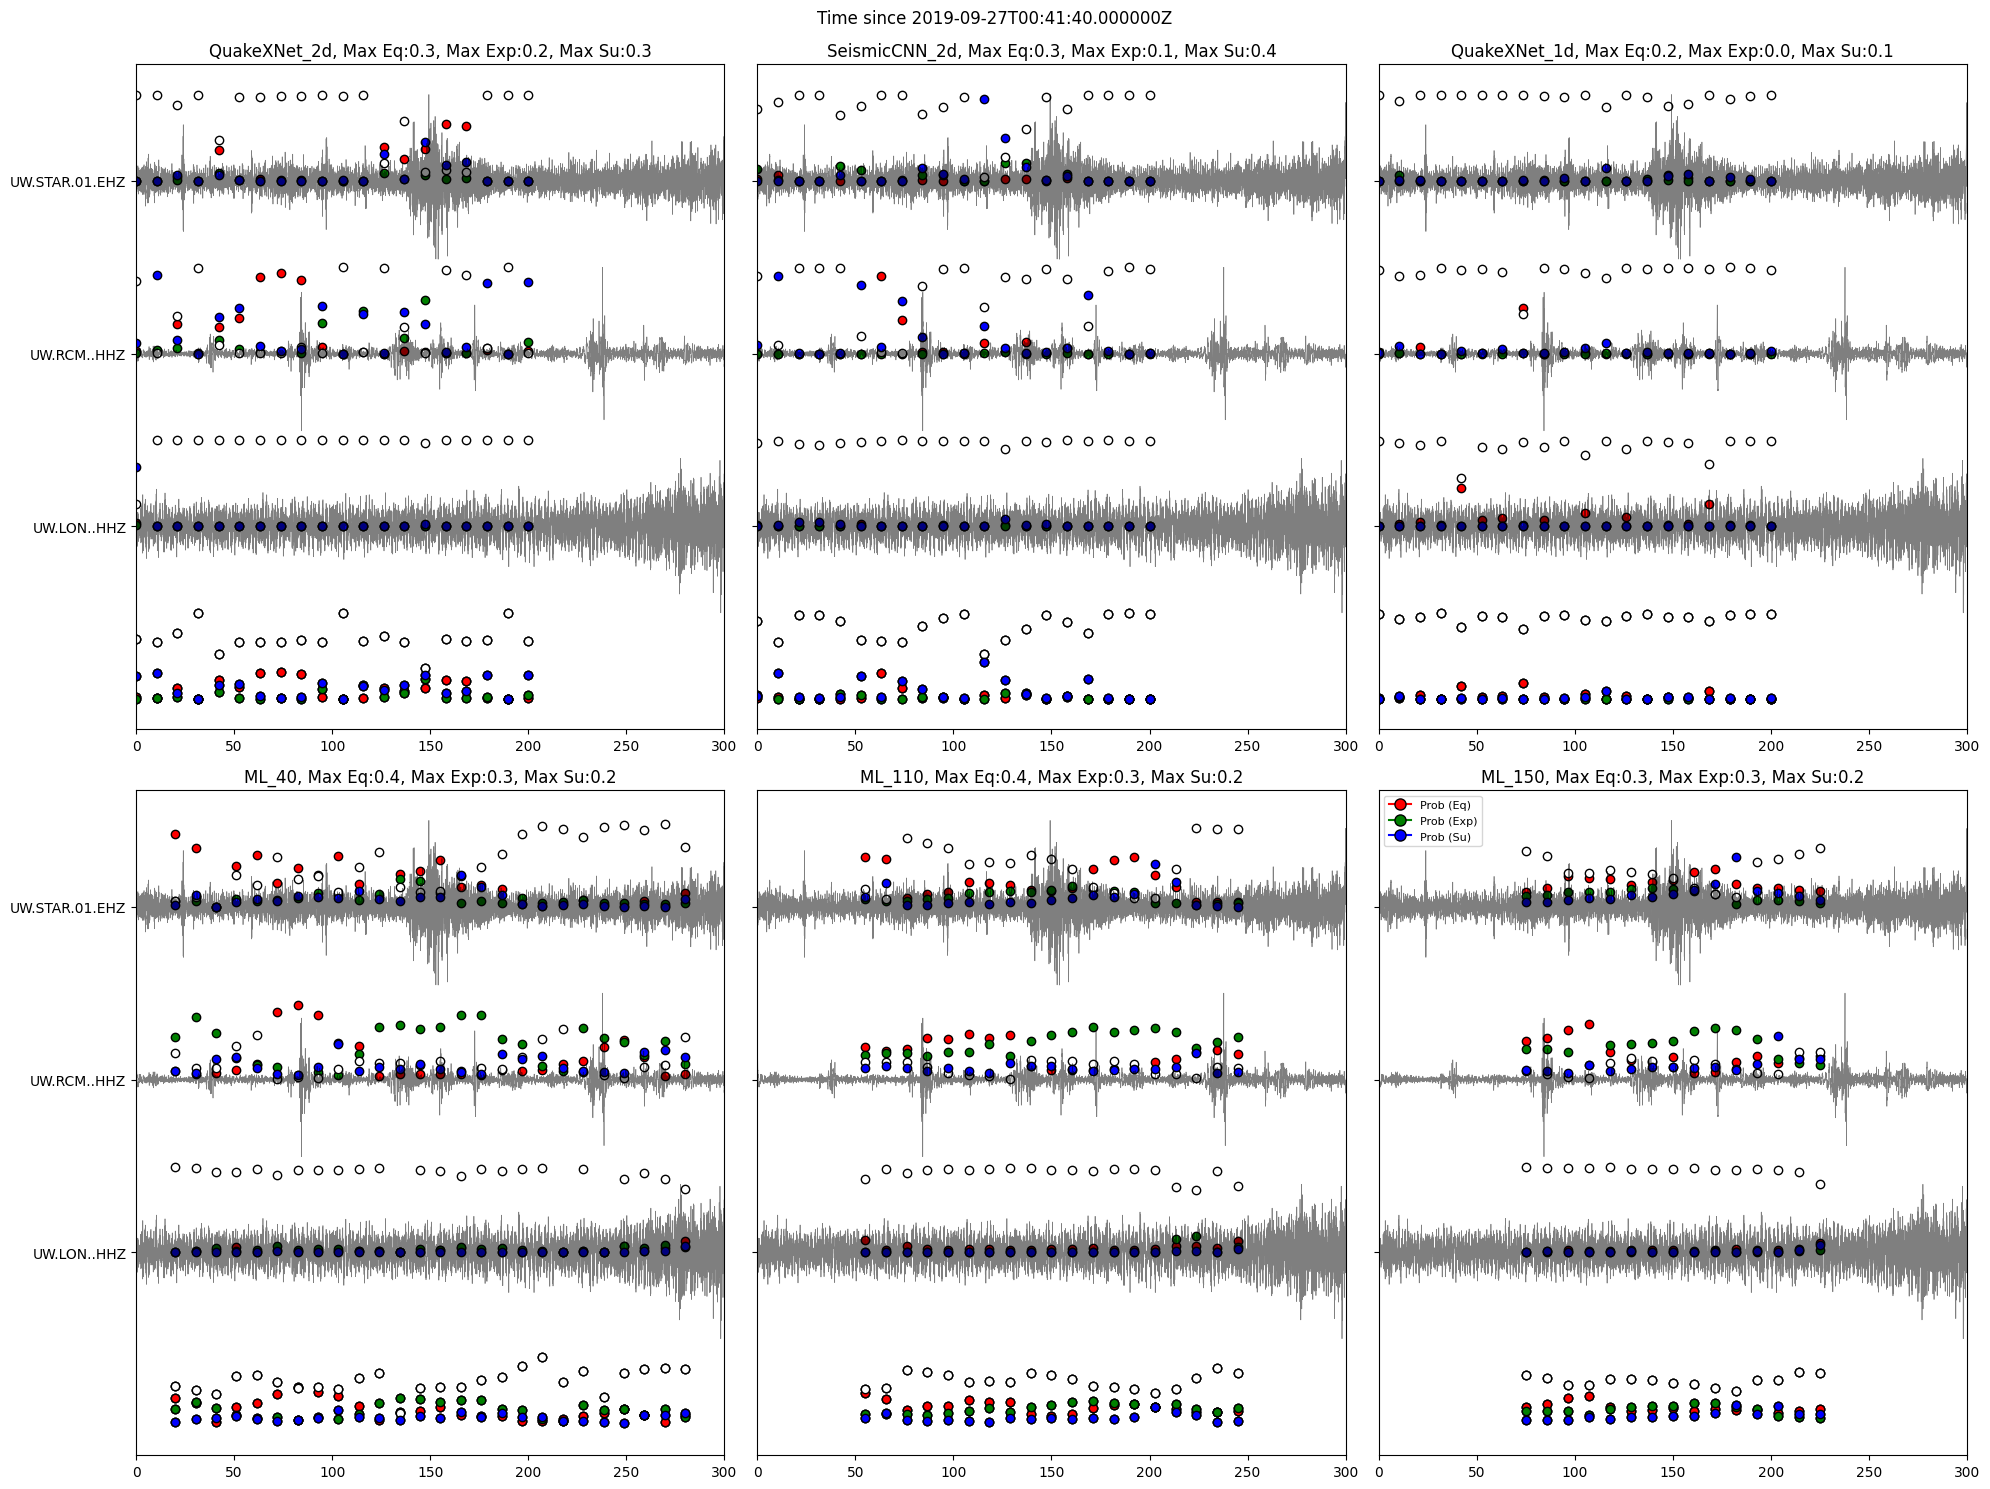

In [12]:
compute_model_preds(start_time, end_time, stations_id, location)

## Another confirmed rockfall, this rockfall fooled the PNSN automated event detection and was labeled as Earthquake initially but further analysis revealed its actually a rockfall

More information about this event can be seen here - 
https://pnsn.org/blog/2015/08/21/summer-rockfall-time-yet-again

In [13]:
before = 100
start_time = obspy.UTCDateTime(2019, 9, 27, 0, 43, 20) - before
end_time = start_time + 300
        
stations_id = [ 'UW.RER', 'UW.RCM', 'UW.STAR', 'UW.RCS', 'UW.FMW', 'UW.WPW', 'CC.PANH']
location = "*"

No valid data available for station RER. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for WPW: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station WPW. Skipping.
No valid data available for station RER. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for WPW: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station WPW. Skipping.
No valid data available for station RER. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for WPW: No data available for request.
HTTP Status code: 204
Detailed response of server:


No valid data available for station WPW. Skipping.
No valid data available for station RER. Skipping.
No valid data available for station RCS. Skipping.
Error fetching station data for WPW: No data available for request.
HTTP Sta

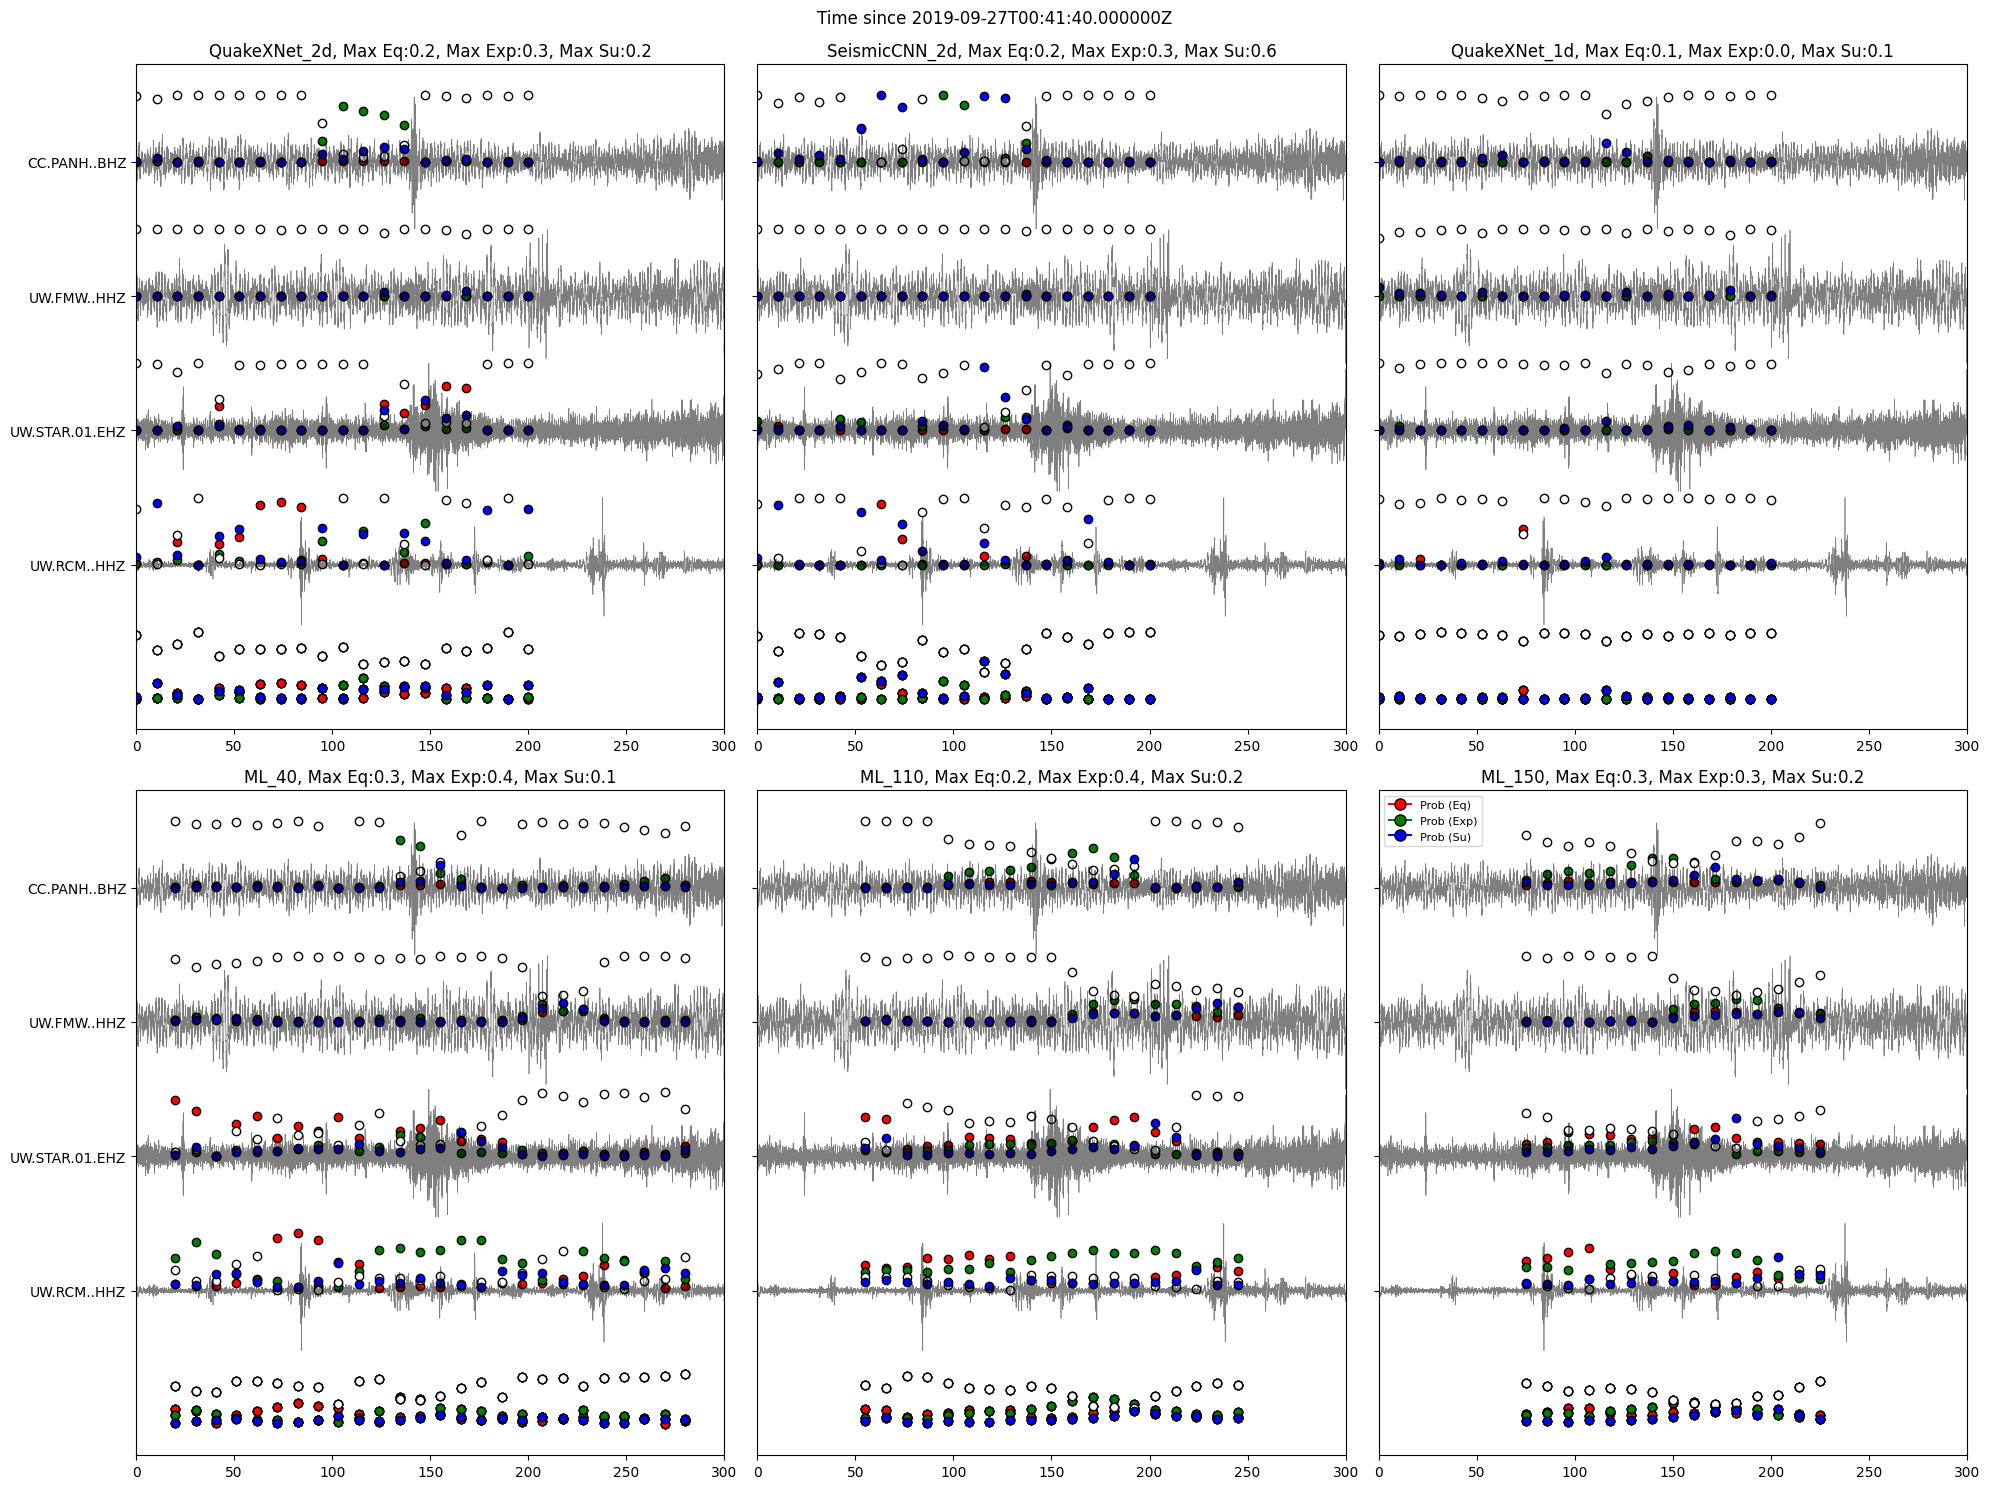

In [14]:
compute_model_preds(start_time, end_time, stations_id, location)

## Testing the model on the events in different region than the model was trained on

- Here we are going to test our model on two large avalanches described very well in this paper - https://esurf.copernicus.org/articles/9/271/2021/ 

These avalanches occur on Iliamna volcano, one in 2016 and other one in 2019

In [15]:
before = 10
start_time = obspy.UTCDateTime(2016, 5, 22, 7, 56, 0) - before
end_time = start_time + 300
        
stations_id = ['AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = "*"

No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.


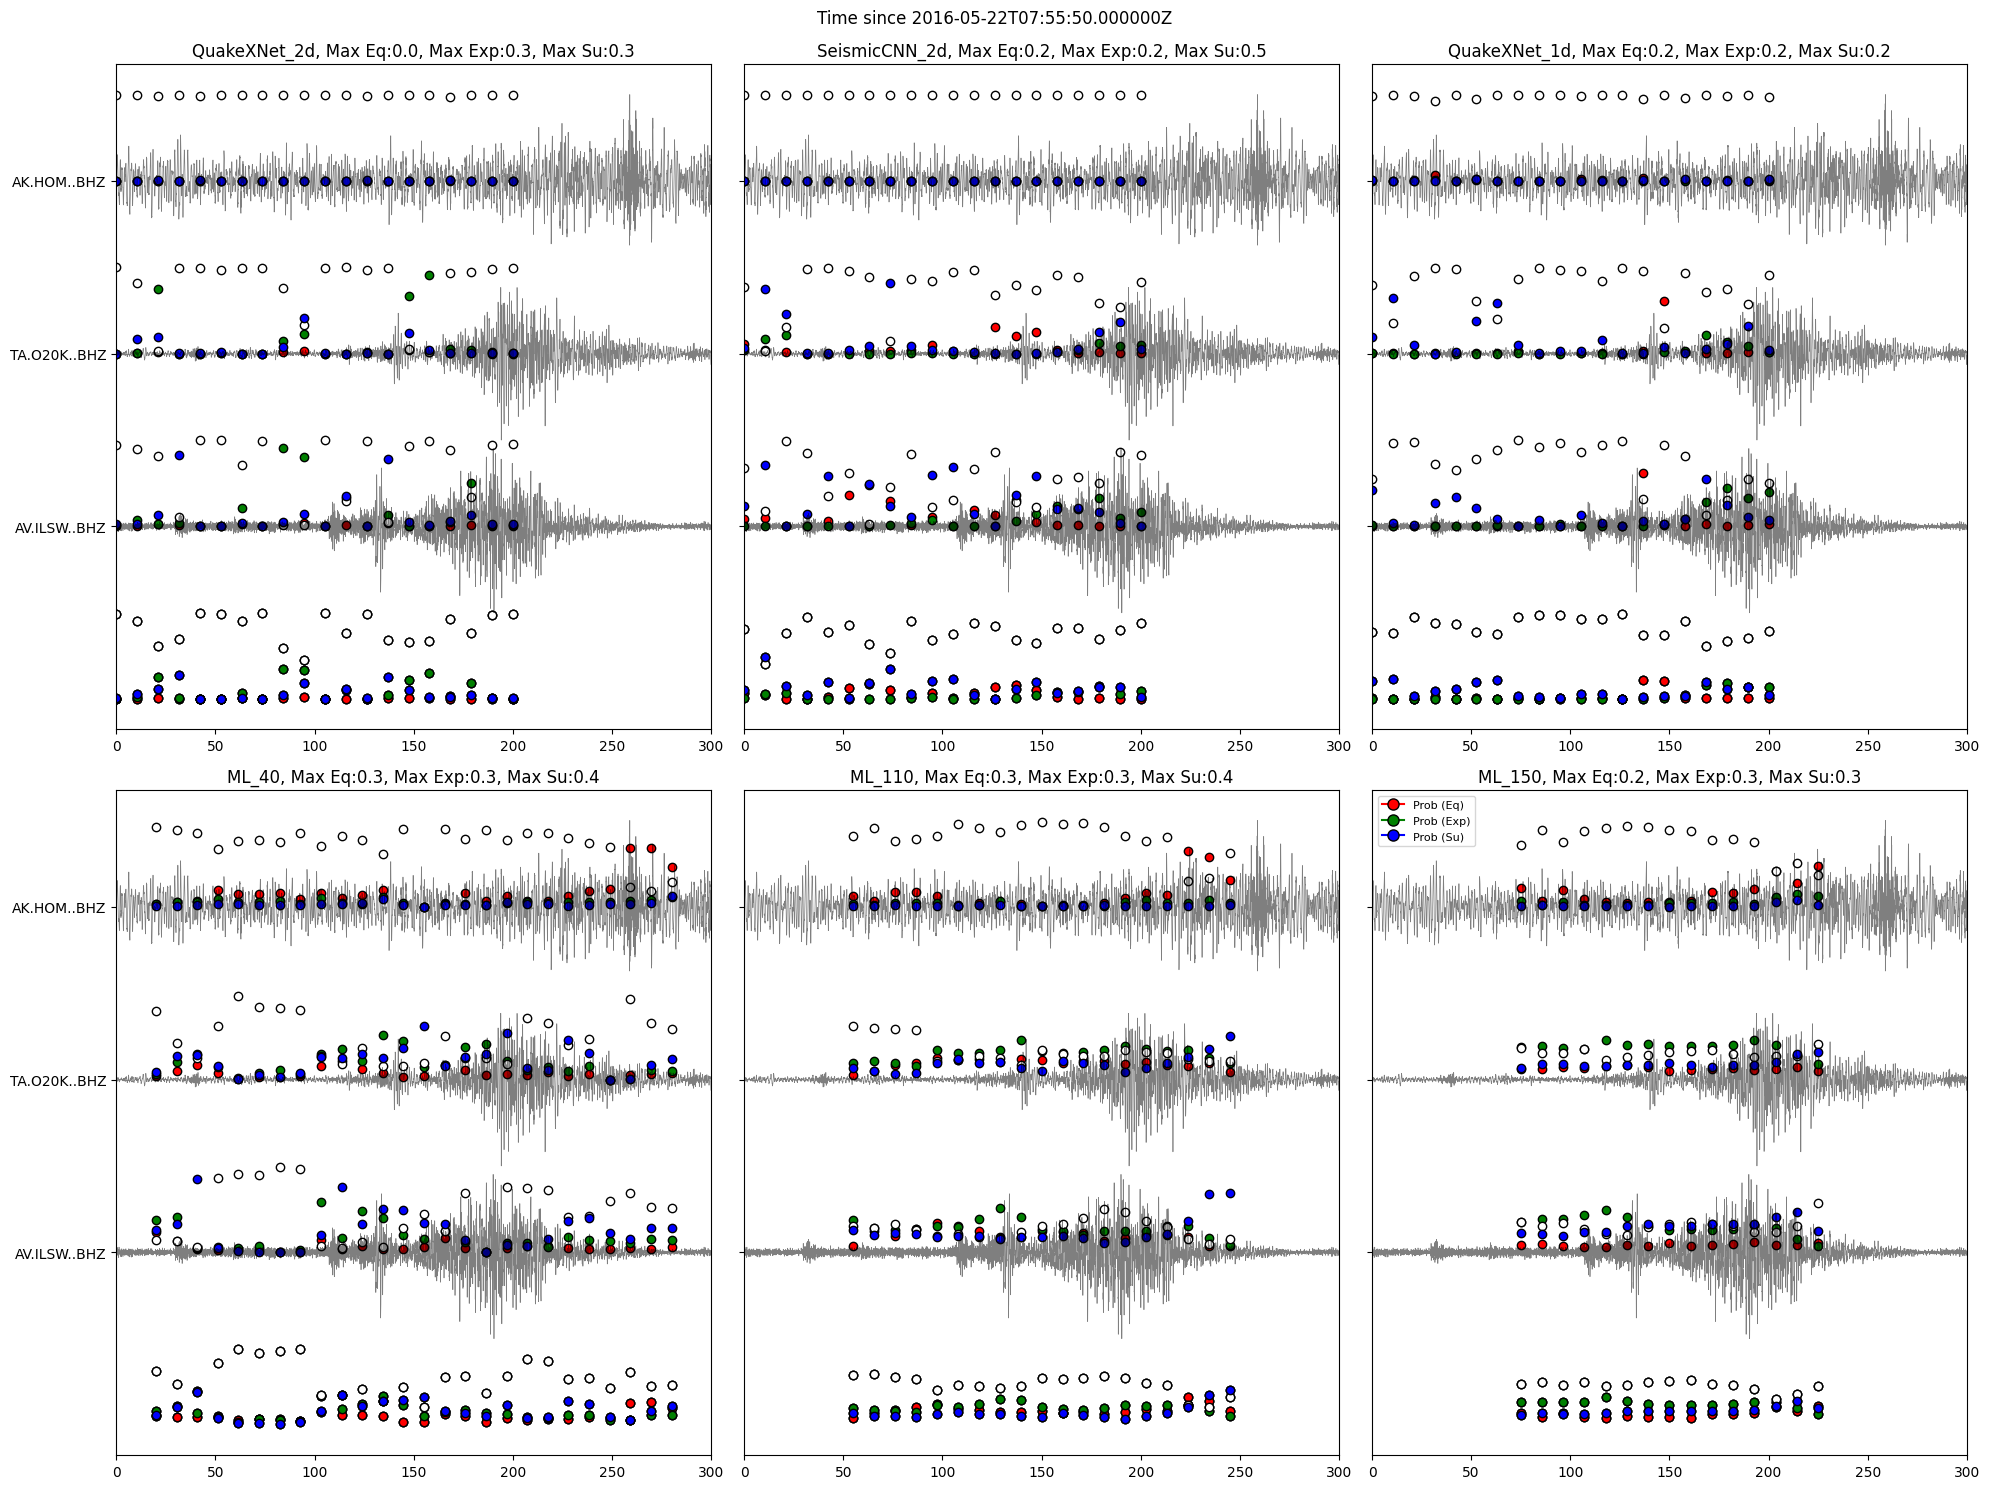

In [16]:
compute_model_preds(start_time, end_time, stations_id, location)

## Testing the model on 2019 event

In [17]:
before = 10
start_time = obspy.UTCDateTime(2019, 6, 21, 0, 0, 1) - before
end_time = start_time + 300
        
stations_id = ['AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = "*"

No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.
No valid data available for station OPT. Skipping.


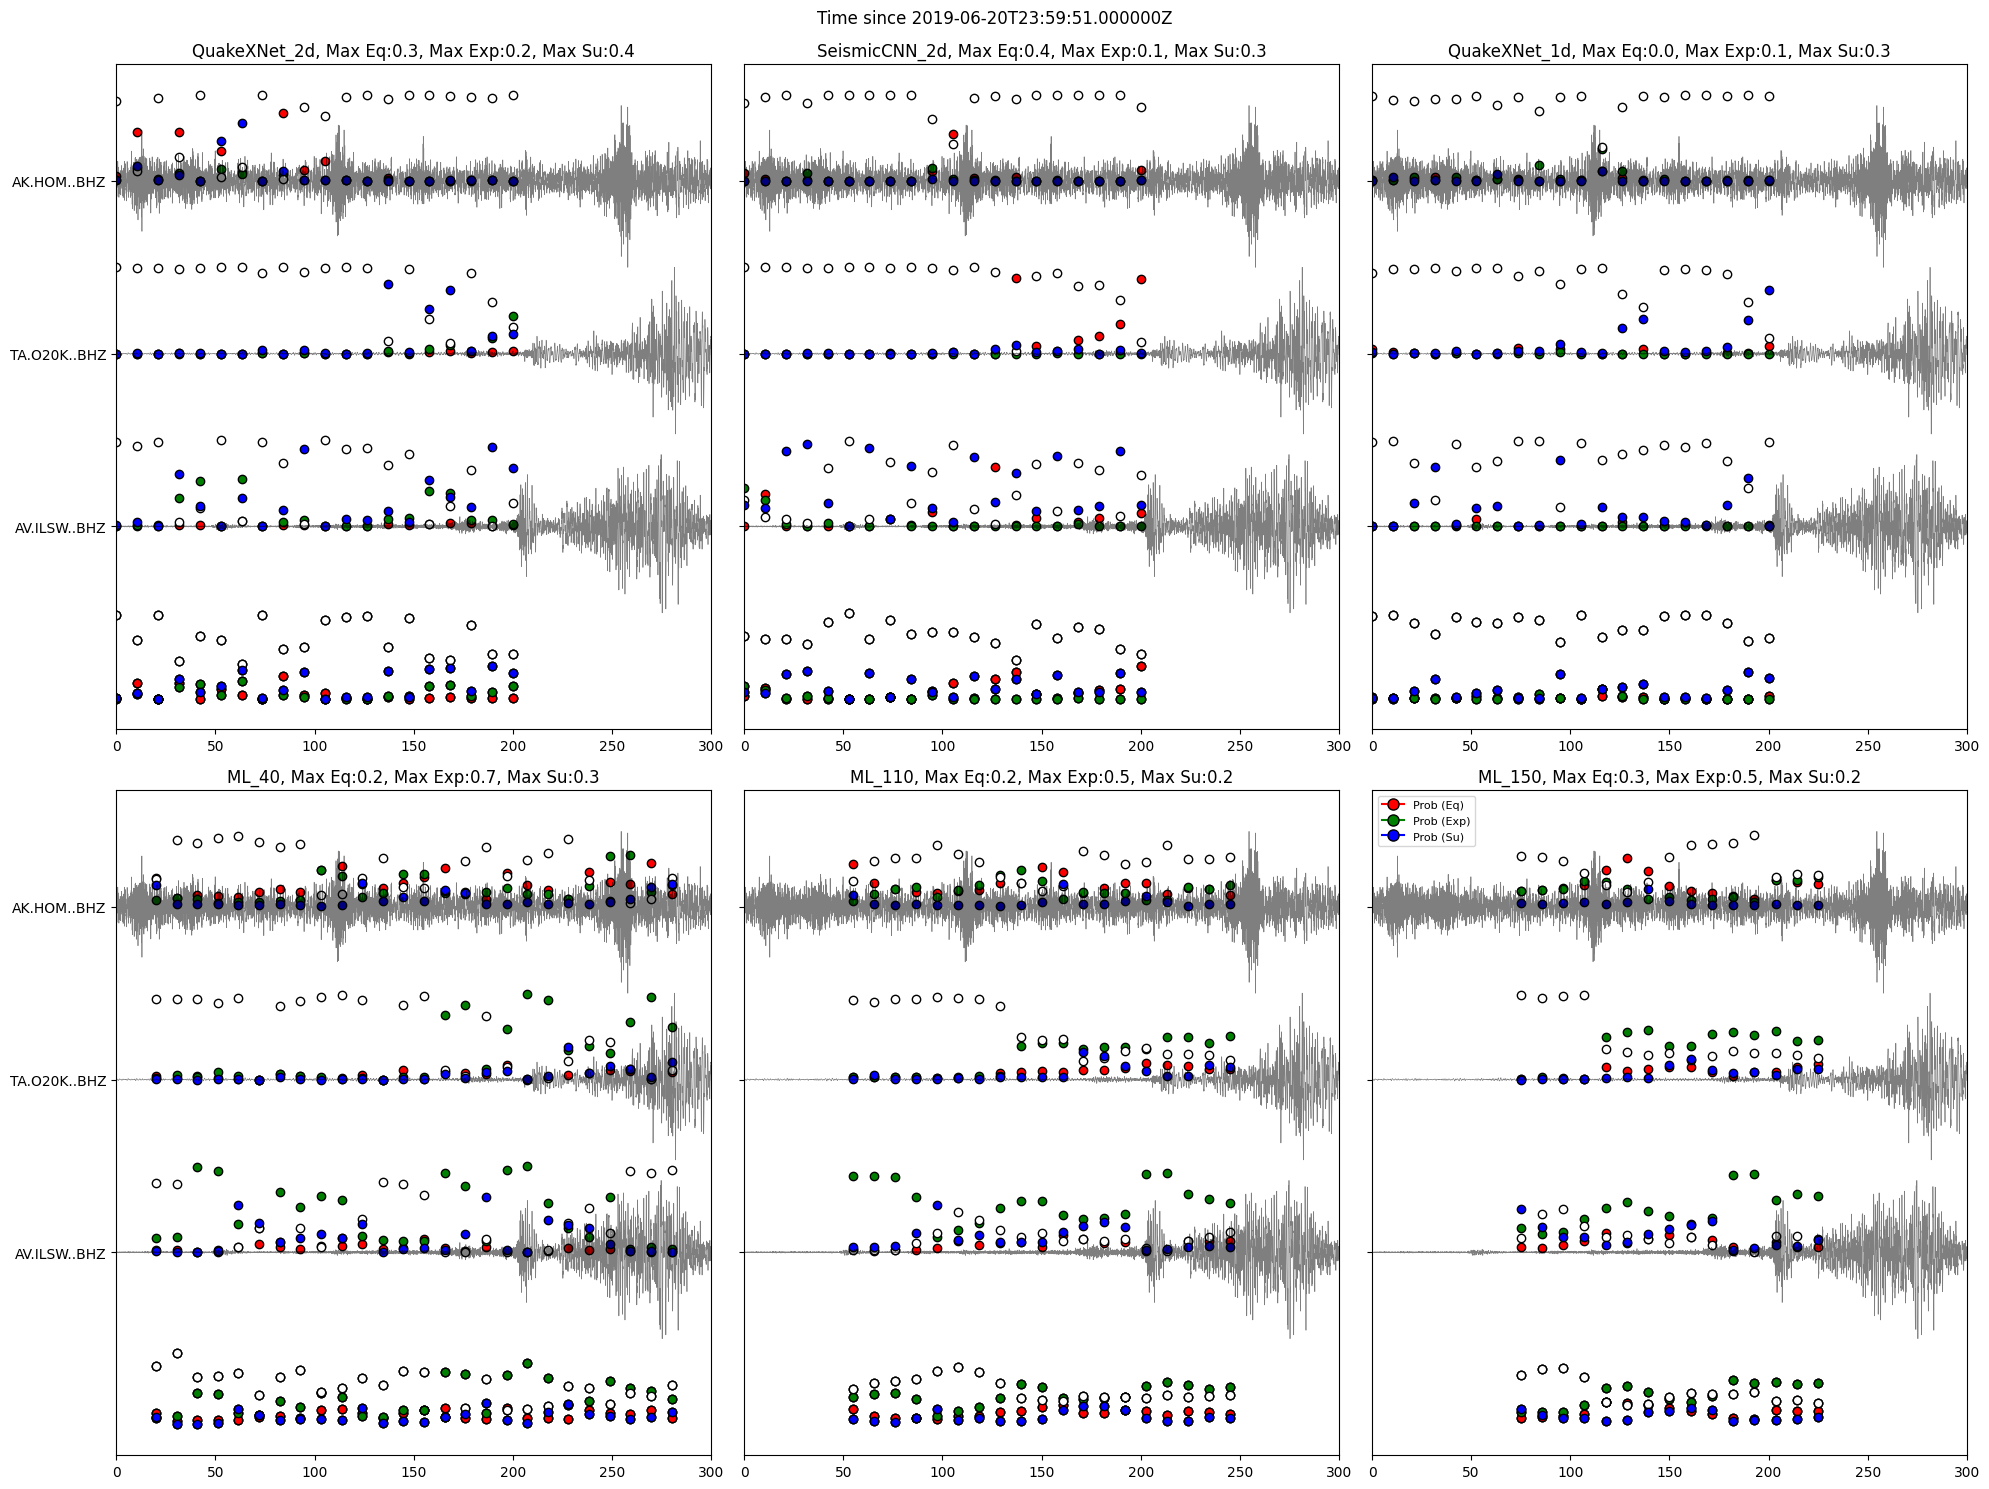

In [18]:
compute_model_preds(start_time, end_time, stations_id, location)

## Deleting the big downloaded files

In [20]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)